In [13]:
import numpy as np
import matplotlib.pylab as plt
np.random.seed(100)

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

In [17]:
a = np.load('Independent_Variables.npy')
b = np.load('Snapshots.npy')
a.shape

(1000, 3)

In [26]:
def ReadData(path_program = './'):
    
    fileIn = path_program + 'Snapshots.npy'
    SnapsAll = np.load(fileIn)

    fileInZ = path_program + 'Independent_Variables.npy'
    TargetsAll = np.load(fileInZ)
    
    
    TrainshuffleOrder = np.arange(SnapsAll.shape[0])
    np.random.shuffle(TrainshuffleOrder)

    Trainfiles = SnapsAll[TrainshuffleOrder]
    TrainZ = TargetsAll[TrainshuffleOrder]

    X_train = Trainfiles[:num_train][:,:,:, None]  # color mag
    X_test = Trainfiles[num_train :][:,:,:, None]   # color mag

    y_train = TrainZ[:num_train]  # spec z
    y_test = TrainZ[num_train :] # spec z

    ## rescaling xmax/xmin
#     xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
#     xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

#     X_train = (X_train - xmin) / (xmax - xmin)
#     X_test = (X_test - xmin) / (xmax - xmin)

#     ymax = np.max([np.max(y_train, axis=0), np.max(y_train, axis=0)], axis=0)
#     ymin = np.min([np.min(y_train, axis=0), np.min(y_train, axis=0)], axis=0)
    
#     ymax = np.max([np.max(y_train), np.max(y_train)])
#     ymin = np.min([np.min(y_train), np.min(y_train)])

#     y_train = (y_train - ymin) / (ymax - ymin)
#     y_test = (y_test - ymin) / (ymax - ymin)


    return X_train, y_train, X_test, y_test#, ymax, ymin, xmax, xmin

In [27]:
# def ReadData(path_program = './'):
    
#     fileIn = path_program + 'inputs.npy'
#     TrainfilesAll = np.load(fileIn)

#     fileInZ = path_program + 'targets.npy'
#     TrainZAll = np.load(fileInZ)


#     TrainshuffleOrder = np.arange(TrainfilesAll.shape[0])
#     np.random.shuffle(TrainshuffleOrder)

#     Trainfiles = TrainfilesAll[TrainshuffleOrder]
#     TrainZ = TrainZAll[TrainshuffleOrder]

#     X_train = Trainfiles[:num_train]  # color mag
#     X_test = Trainfiles[num_train :]  # color mag

#     y_train = TrainZ[:num_train]  # spec z
#     y_test = TrainZ[num_train :] # spec z

#     ## rescaling xmax/xmin
# #     xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
# #     xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

# #     X_train = (X_train - xmin) / (xmax - xmin)
# #     X_test = (X_test - xmin) / (xmax - xmin)

# #     ymax = np.max([np.max(y_train, axis=0), np.max(y_train, axis=0)], axis=0)
# #     ymin = np.min([np.min(y_train, axis=0), np.min(y_train, axis=0)], axis=0)
    
# #     ymax = np.max([np.max(y_train), np.max(y_train)])
# #     ymin = np.min([np.min(y_train), np.min(y_train)])

# #     y_train = (y_train - ymin) / (ymax - ymin)
# #     y_test = (y_test - ymin) / (ymax - ymin)


#     return X_train, y_train, X_test, y_test#, ymax, ymin, xmax, xmin

In [30]:
X_train, y_train, X_test, y_test = ReadData(path_program = './')

In [32]:
X_test.shape

(910, 64, 64, 1)

In [24]:
num_components = 1
input_shape = 2
output_shape = [400]

n_epochs = 500
learning_rate = 1e-2
decay_rate = 0.0
num_train = 90
num_test = 10 

In [4]:
# X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadData(path_program = './')
X_train, y_train, X_test, y_test = ReadData(path_program = './')

print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (90, 2)
Size of output in training data: (90, 400)
Size of features in test data: (10, 2)
Size of output in test data: (10, 400)


In [5]:
model = keras.Sequential([
    keras.layers.Dense(units=8, activation='relu', input_shape=(input_shape,)),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=256, activation='tanh'),
    keras.layers.Dense(units=512, activation='tanh'),
    keras.layers.Dense(tfp.layers.MixtureNormal.params_size(num_components, output_shape)),
    tfp.layers.MixtureNormal(num_components, output_shape)
#     keras.layers.Dense(units=num_components*3),
#     tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#         tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=tf.expand_dims(t[..., :num_components], -2)),
#                               components_distribution=tfd.Beta(1 + tf.nn.softplus(tf.expand_dims(t[..., num_components:2*num_components], -2)),
#                                                                1 + tf.nn.softplus(tf.expand_dims(t[..., 2*num_components:],-2)))), 1))
    ])

negloglik = lambda y, p_y: -p_y.log_prob(y)

callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1= decay_rate, amsgrad = True)
model.compile(loss=negloglik, optimizer=opt, metrics=[])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=2, callbacks=[callback], verbose=0)

Text(0,0.5,'Loss')

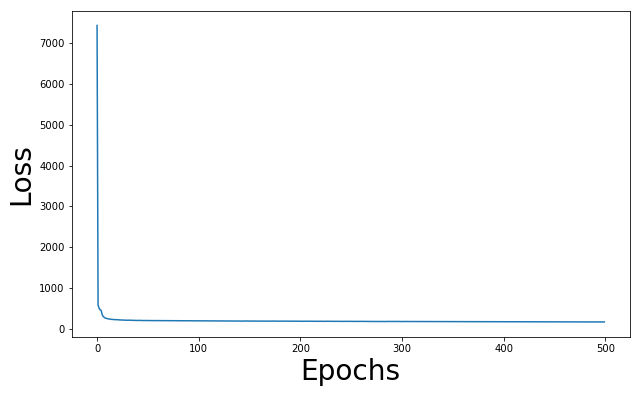

In [7]:
## Plotting loss function
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.xlabel('Epochs', fontsize = 28)
plt.ylabel('Loss', fontsize = 28)

In [8]:
y_pred = model(X_test)
y_pred_mean = y_pred.components_distribution.mean() 
y_pred_variance = y_pred.components_distribution.variance() 
y_pred_std = np.sqrt(y_pred_variance)
# y_test = (ymax - ymin)*(y_test + ymin)

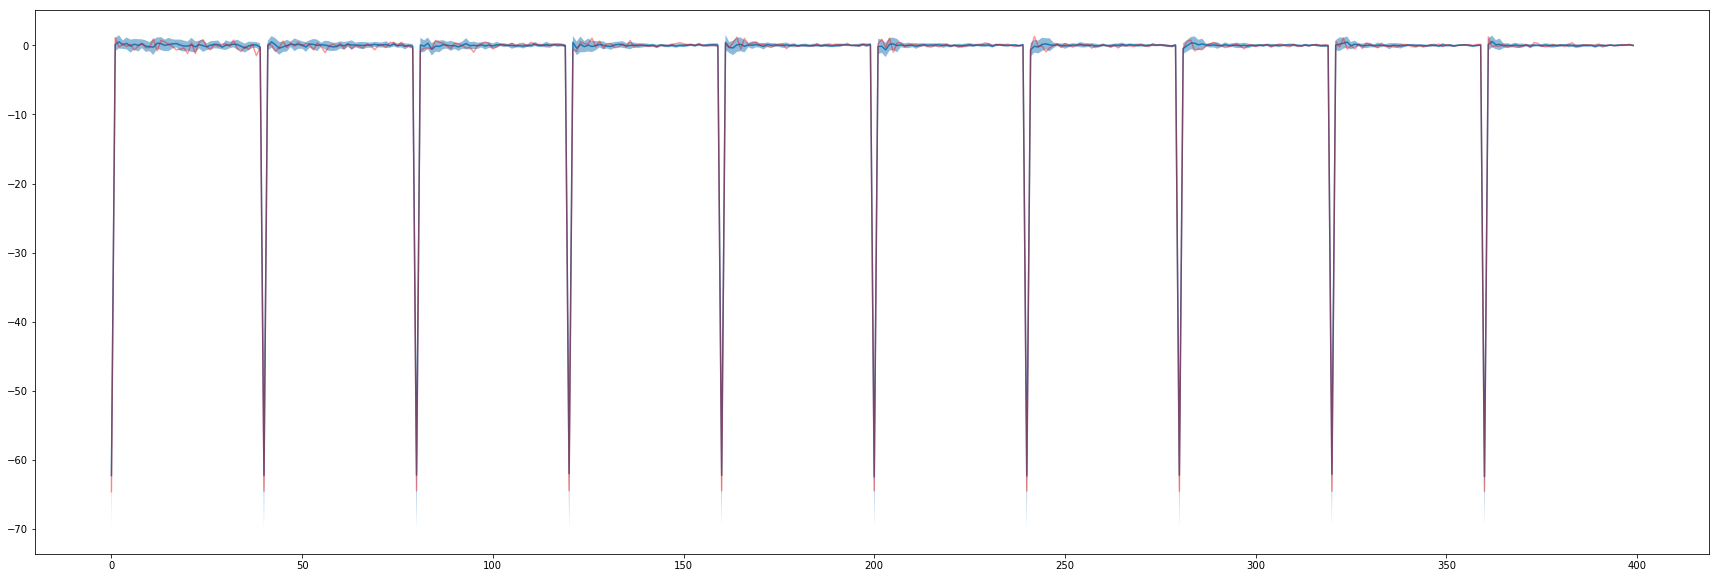

In [9]:
plt.figure(figsize = (30, 10))
x = np.arange(400)

idx_test = [2]

for idx in idx_test:
    
    plt.plot(x, y_pred_mean[idx, 0, :])
    plt.fill_between(x, y_pred_mean[idx, 0, :] - y_pred_std[idx, 0, :], y_pred_mean[idx, 0, :] + y_pred_std[idx, 0, :], alpha = 0.5)
    plt.plot(x, y_test[idx], 'r', alpha = 0.4)
# plt.yscale('symlog')
plt.show()


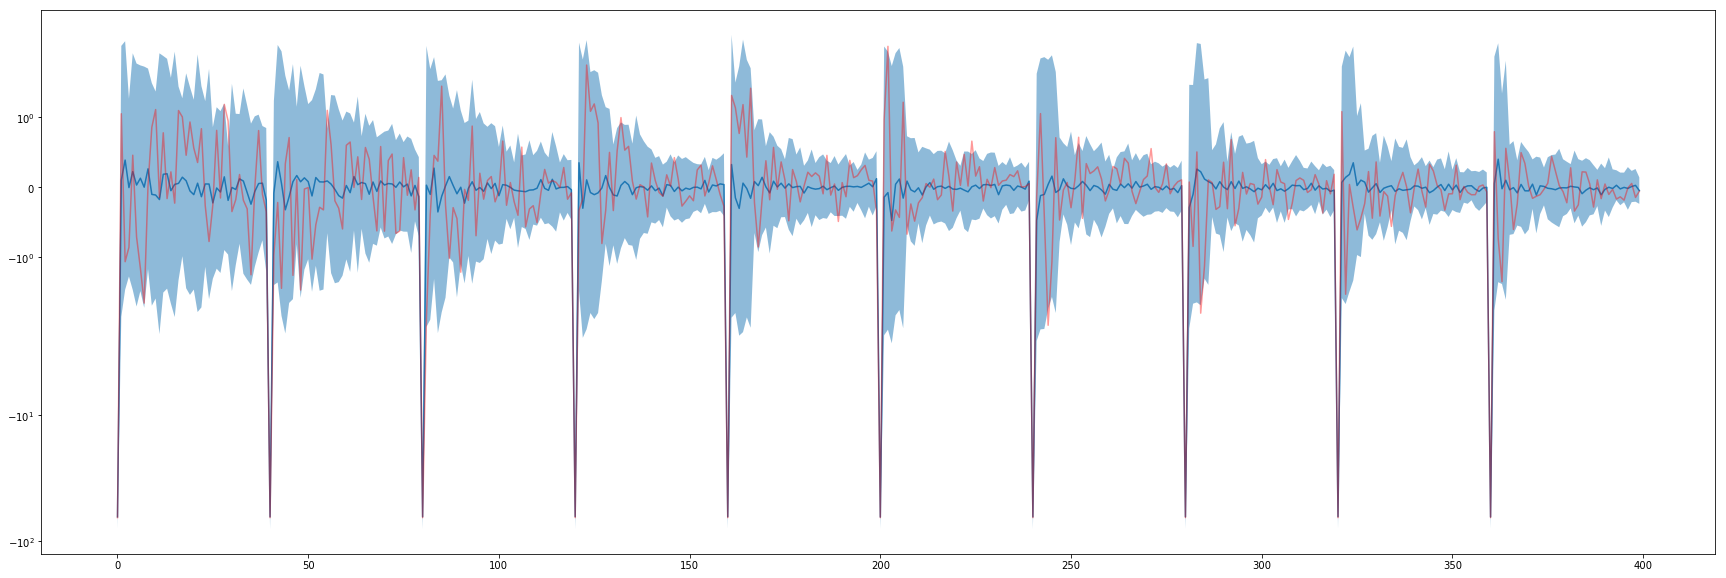

In [10]:
### Closer look near 0. error bars at 2 sigma

plt.figure(figsize = (30, 10))
x = np.arange(400)
plt.plot(x, y_pred_mean[0, 0, :])
plt.fill_between(x, y_pred_mean[0, 0, :] - 2*y_pred_std[0, 0, :], y_pred_mean[0, 0, :] + 2*y_pred_std[0, 0, :], alpha = 0.5)
plt.plot(x, y_test[0], 'r', alpha = 0.4)
plt.yscale('symlog')
plt.show()

In [13]:
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
np.save('y_test_mean.npy', y_pred_mean[:, 0, :])
np.save('y_test_std.npy', y_pred_std[:, 0, :])